In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

In [3]:
# Load data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path=("/content/drive/MyDrive/image_caption")

In [5]:
import pandas as pd
# Paths for dataset
IMG_PATH = '/content/drive/MyDrive/image_caption/archive/Images/'
CAPTION_PATH = '/content/drive/MyDrive/image_caption/archive/captions.txt'

# Define image size for the model
IMG_SIZE = (299, 299)

#  Load captions
# def load_captions(file_path):
#     captions = pd.read_csv(file_path, delimiter=',')
#     captions.columns = ['image', 'caption']
#     return captions

# captions = load_captions(CAPTION_PATH)
# print(captions.head())

df = pd.read_csv(CAPTION_PATH)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


visualizing the Images and their corresponding captions.

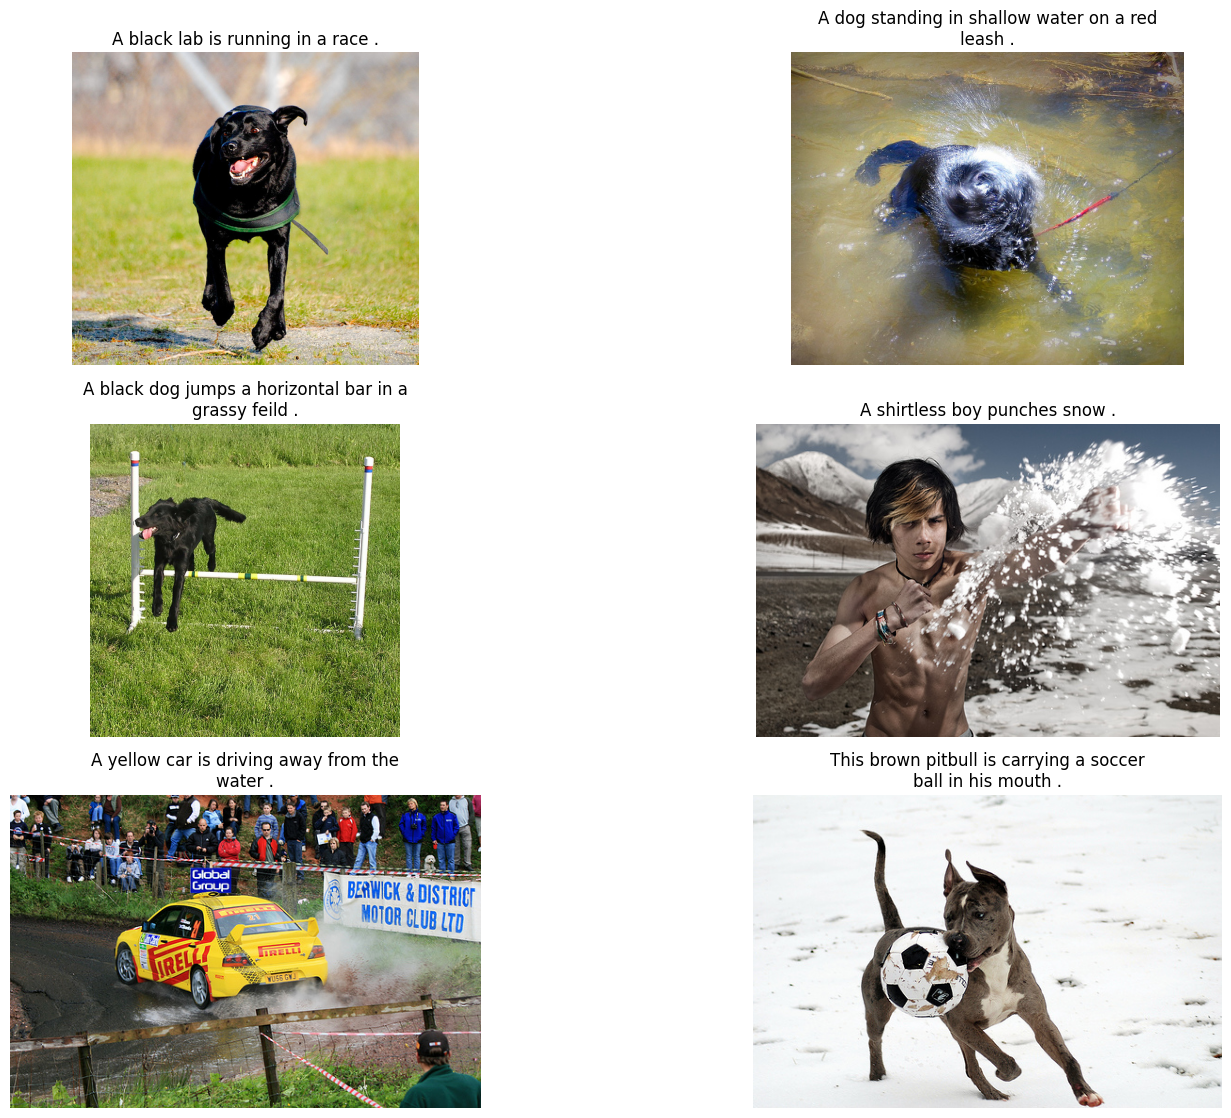

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import os
from textwrap import wrap

# Function to load and preprocess an image
def load_image(image_path):
    return Image.open(image_path)

# Function to visualize images with their captions
def visualize_images_with_captions(df, img_path, num_samples=5):
    """
    Visualize a subset of images from the dataset along with their captions.

    Args:
    - df (DataFrame): The dataset containing image names and captions.
    - img_path (str): Path to the folder containing the images.
    - num_samples (int): Number of samples to visualize.
    """
    plt.figure(figsize=(15, 15))

    # Randomly select a subset of the dataset
    sample_df = df.sample(num_samples).reset_index(drop=True)

    for i in range(num_samples):
        image_name = sample_df.loc[i, 'image']
        caption = sample_df.loc[i, 'caption']

        # Load the image
        image = load_image(os.path.join(img_path, image_name))

        # Plot the image
        plt.subplot(num_samples // 2 + 1, 2, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title("\n".join(wrap(caption, 40)), fontsize=12)

    plt.tight_layout()
    plt.show()

# Visualize a few samples
visualize_images_with_captions(df, IMG_PATH, num_samples=6)


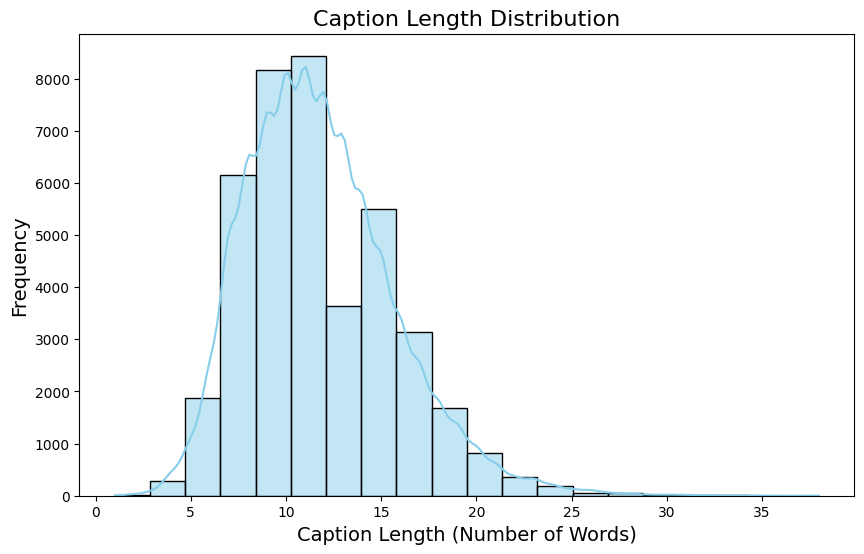

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

# Calculate the length of each caption
caption_lengths = df['caption'].apply(lambda x: len(x.split()))

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(caption_lengths, bins=20, kde=True, color='skyblue')
plt.xlabel("Caption Length (Number of Words)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Caption Length Distribution", fontsize=16)
plt.show()



In [8]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [9]:
df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [10]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


In [11]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [12]:
display(df.head(2))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


In [13]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [14]:
print(len(word_dict))
print(word_dict[:5])

8360
['<pad>', '<start>', '<end>', 'in', 'the']


In [15]:
vocab_size = len(word_dict)
print(vocab_size)

8360


In [16]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


In [17]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [18]:
display(df.head(2))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [19]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]
test = df.iloc[int(0.9*len(df)):]

In [20]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


In [21]:
train_samples = len(train)
print(train_samples)

36409


In [22]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
unq_test_imgs = test[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs), len(unq_test_imgs))

7282 810 810


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [24]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = '/content/drive/MyDrive/image_caption/archive/Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [25]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [26]:
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [27]:
# Assuming unq_test_imgs contains unique test images
test_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_test_imgs)

# Create a DataLoader for the test dataset
test_ImageDataloader_ResNet = DataLoader(
    test_ImageDataset_ResNet,
    batch_size=1,  # Use batch size of 1 for testing or adjust as needed
    shuffle=False  # No shuffling for test data
)

# Print confirmation
print(f"Test DataLoader created with {len(test_ImageDataloader_ResNet)} batches.")


Test DataLoader created with 810 batches.


In [28]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [29]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [30]:
def get_vector(t_img):

    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)

    h.remove()
    return my_embedding

**Feature Extraction in Images**
*   The photos' features are extracted using the ResNet Architecture.
* picture embeddings will be 1920-pixel vectors since the Global Average Pooling layer is chosen as the ResNet model's last layer for our feature extraction.



In [31]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/7282 [00:00<?, ?it/s]

In [32]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [33]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/810 [00:00<?, ?it/s]

In [34]:
a_file = open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

In [35]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [36]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [37]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

In [38]:
test_dataset_resnet = FlickerDataSetResnet(test, 'EncodedImageValidResNet.pkl')
test_dataloader_resnet = DataLoader(test_dataset_resnet, batch_size = 32, shuffle=True)

In [39]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, dropout=0.1, max_len=5000): # Changed _init_ to __init__
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * -(math.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_len, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [40]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)


        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)

        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)


        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)


        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)

        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask


In [41]:
EPOCH = 30

In [42]:
import torch
import numpy as np

# Initialize your model
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
input_size = train_samples

# torch.save(ictModel.state_dict(), "image_caption_model.pth")
torch.save({
    'model_state_dict': ictModel.state_dict(),
    'input_size': input_size,
    'hidden_sizes': [128, 64],  # Example hidden layer sizes
    'output_size': 3,
},'model.pth')

# Define optimizer
optimizer = torch.optim.AdamW(ictModel.parameters(), lr=0.0001, weight_decay=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2)

# Define loss function
criterion = nn.CrossEntropyLoss(reduction='none', label_smoothing=0.1)

# Correct initialization of min_val_loss
min_val_loss = float('inf')  # Replace np.float('Inf') with Python's built-in float type


DATA GENERATION

Generate the data in the necessary format batch-wise since training the Image Caption model, like training any neural network, uses a lot of resources. As a result, we cannot load the data into the main memory all at once.
For the training procedure, the inputs will be the image embeddings and the corresponding caption text embeddings. During the inference period, the caption generation process receives the text embeddings word by word.

In [43]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    total_train_correct = 0
    total_valid_correct = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

                # Accuracy Calculation
        predictions = torch.argmax(output, dim=1)
        correct_predictions = torch.sum((predictions == target_seq) * padding_mask).detach().item()
        total_train_correct += correct_predictions


    total_epoch_train_loss = total_epoch_train_loss/total_train_words
    train_accuracy = total_train_correct / total_train_words


    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)
            # Accuracy Calculation
            predictions = torch.argmax(output, dim=1)
            correct_predictions = torch.sum((predictions == target_seq) * padding_mask).detach().item()
            total_valid_correct += correct_predictions

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words

    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
    valid_accuracy = total_valid_correct / total_valid_words

    print(f"Epoch -> {epoch} | Training Loss -> {total_epoch_train_loss:.4f} | Eval Loss -> {total_epoch_valid_loss:.4f} "
          f"| Train Accuracy -> {train_accuracy:.4f} | Eval Accuracy -> {valid_accuracy:.4f}")


    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss


    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch ->  0  Training Loss ->  4.721285343170166 Eval Loss ->  4.244790554046631
Epoch -> 0 | Training Loss -> 4.7213 | Eval Loss -> 4.2448 | Train Accuracy -> 0.3327 | Eval Accuracy -> 0.3666
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.011295795440674 Eval Loss ->  4.047079563140869
Epoch -> 1 | Training Loss -> 4.0113 | Eval Loss -> 4.0471 | Train Accuracy -> 0.3972 | Eval Accuracy -> 0.3867
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.71523118019104 Eval Loss ->  3.977501392364502
Epoch -> 2 | Training Loss -> 3.7152 | Eval Loss -> 3.9775 | Train Accuracy -> 0.4339 | Eval Accuracy -> 0.3973
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.4828004837036133 Eval Loss ->  3.960536241531372
Epoch -> 3 | Training Loss -> 3.4828 | Eval Loss -> 3.9605 | Train Accuracy -> 0.4678 | Eval Accuracy -> 0.4006
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.2792980670928955 Eval Loss ->  3.969197988510132
Epoch -> 4 | Training Loss -> 3.2793 | Eva

In [44]:
torch.save(ictModel.state_dict(), "image_caption_model.pth")

In [45]:
ictModel.load_state_dict(torch.load("image_caption_model.pth"))
ictModel.eval()  # Set to evaluation mode if necessary


<ipython-input-45-eb9b80e4857c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ictModel.load_state_dict(torch.load("image_caption_model.pth"))


ImageCaptionModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoderLayer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoder): Transfor

In [46]:
import h5py

# Save the state_dict as an HDF5 file
state_dict = ictModel.state_dict()
with h5py.File("image_caption_model1.h5", "w") as h5_file:
    for key, value in state_dict.items():
        h5_file.create_dataset(key, data=value.cpu().numpy())


In [47]:
with h5py.File("image_caption_model1.h5", "r") as h5_file:
    state_dict = {key: torch.tensor(h5_file[key][:]) for key in h5_file.keys()}

ictModel.load_state_dict(state_dict)
ictModel.eval()

ImageCaptionModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoderLayer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoder): Transfor

In [48]:
def test_model(model, test_dataloader, criterion, device):
    """
    Evaluate the trained model on the test dataset.

    Args:
    - model: Trained PyTorch model.
    - test_dataloader: DataLoader for the test dataset.
    - criterion: Loss function used during training.
    - device: Device to perform evaluation (CPU or GPU).

    Returns:
    - test_loss: Average loss on the test dataset.
    - test_accuracy: Accuracy on the test dataset.
    """
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0
    total_test_correct = 0
    total_test_words = 0

    with torch.no_grad():  # Disable gradient calculations
        for caption_seq, target_seq, image_embed in test_dataloader:
            # Move data to device
            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            # Forward pass
            output, padding_mask = model(image_embed, caption_seq)
            output = output.permute(1, 2, 0)  # Permute dimensions for loss calculation

            # Calculate loss
            loss = criterion(output, target_seq)
            loss_masked = torch.mul(loss, padding_mask)  # Mask out padding loss
            total_test_loss += torch.sum(loss_masked).detach().item()

            # Calculate accuracy
            preds = torch.argmax(output, dim=1)  # Get predicted token indices
            total_test_correct += (preds == target_seq).float().sum().item()
            total_test_words += torch.sum(padding_mask).item()

    # Calculate average test loss and accuracy
    test_loss = total_test_loss / total_test_words
    test_accuracy = (total_test_correct / total_test_words) * 100  # Accuracy as a percentage

    return test_loss, test_accuracy


In [49]:
test_loss, test_accuracy = test_model(ictModel, test_dataloader_resnet, criterion, device)

# Print test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 4.7362
Test Accuracy: 89.90%


In [50]:
model = torch.load('./BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


<ipython-input-50-5bd88ef4ee10>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./BestModel')


In [51]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [52]:
def generate_caption(K, img_nm):
    img_loc = '/content/drive/MyDrive/image_caption/archive/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval()
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))
    return " ".join(predicted_sentence+['.'])

In [53]:
from transformers import MarianMTModel, MarianTokenizer
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch

# Translator Class
class Translator:
    def __init__(self, source_lang="en", target_lang="es"):  # Updated target_lang to Malayalam
        """
        Initialize the translation model.
        :param source_lang: Source language code (default: "en" for English).
        :param target_lang: Target language code (e.g., "es" for spanish).
        """
        model_name = f"Helsinki-NLP/opus-mt-{source_lang}-{target_lang}"
        self.tokenizer = MarianTokenizer.from_pretrained(model_name)
        self.model = MarianMTModel.from_pretrained(model_name)

    def translate(self, text):
        """
        Translate the input text to the target language.
        :param text: Input text in the source language.
        :return: Translated text in the target language.
        """
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        translated = self.model.generate(**inputs)
        return self.tokenizer.decode(translated[0], skip_special_tokens=True)


# Caption Generation with Translation
def generate_caption_with_translation(
    K, img_nm, model, translator, max_seq_len=33, start_token=0, pad_token=0, end_token=0
):
    """
    Generate captions for the image and translate them into the desired language.
    :param K: Number of top predictions to sample from.
    :param img_nm: Image filename.
    :param model: Trained Image Captioning Model.
    :param translator: Translator object for translating captions.
    :param max_seq_len: Maximum sequence length for captions.
    :param start_token: Start token index.
    :param pad_token: Padding token index.
    :param end_token: End token index.
    :return: None (prints translated captions).
    """
    # Load and display the image
    img_loc = '/content/drive/MyDrive/image_caption/archive/Images/' + str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Get embeddings for the image
    model.eval()
    valid_img_df = valid[valid['image'] == img_nm]  # Ensure valid is defined earlier
    print("Actual Caption:")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)  # Ensure valid_img_embed is defined earlier

    # Reshape embeddings
    img_embed = img_embed.permute(0, 2, 3, 1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

    # Initialize the input sequence
    input_seq = [pad_token] * max_seq_len
    input_seq[0] = start_token
    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)

    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):
            output, padding_mask = model.forward(img_embed, input_seq)
            output = output[eval_iter, 0, :]
            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            # Select next word
            next_word_index = random.choices(indices, values, k=1)[0]
            next_word = index_to_word[next_word_index]  # Ensure index_to_word is defined earlier
            input_seq[:, eval_iter + 1] = next_word_index

            if next_word == '<end>':
                break
            predicted_sentence.append(next_word)

    print("\nPredicted Caption:")
    generated_caption = " ".join(predicted_sentence + ['.'])
    print(generated_caption)

    # Translate the caption
    translated_caption = translator.translate(generated_caption)
    print("\nTranslated Caption:")
    print(translated_caption)


# Example Usage
source_language = "en"
target_language = "es"  # Translate to spanish
translator = Translator(source_lang=source_language, target_lang=target_language)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Actual Caption : 
['Four small dogs play outside .', 'Four medium-sized dogs wrestle with each other on a grass field .', 'Four dogs in a grassy area .', 'A cluster of four brown dogs play in a field of brown grass .', 'Four dogs are together in the field of dry grass .']


Predicted caption : 
three dogs are playing in the grass .

Translated Caption:
tres perros están jugando en el césped.


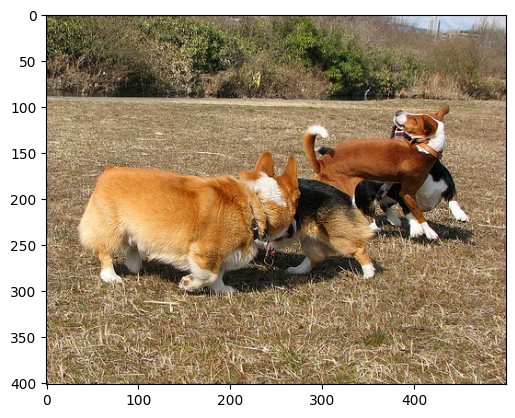

In [71]:
caption = generate_caption(1, unq_valid_imgs.iloc[10]['image'])

translated_caption = translator.translate(str(caption))
print("\nTranslated Caption:")
print(translated_caption)

Actual Caption : 
['A brown dog fetching a ball out of the water .', 'A brown dog is climbing out of the water with a green ball in its mouth .', 'A brown dog is pulling itself out of the water onto some rocks with a tennis ball in its mouth .', 'A dog fetches a tennis ball out of a pool of water .', 'A dog with a ball in its mouth getting out of the water .']


Predicted caption : 
brown dog swimming in water .

Translated Caption:
perro marrón nadando en el agua.


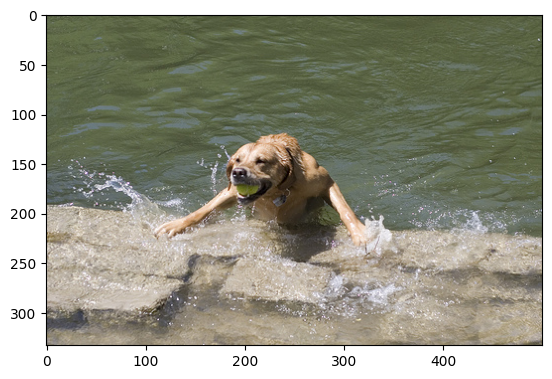

In [63]:
caption = generate_caption(1, unq_valid_imgs.iloc[290]['image']) # Assign the return value of the function to the variable "caption"
translated_caption = translator.translate(str(caption))
print("\nTranslated Caption:")
print(translated_caption)

Actual Caption : 
['Two black , brown and white dogs running in green grass with ears up on heads .', 'Two dogs run through a field of grass', 'Two fluffy dogs run through the grass .', 'Two look-alike dogs running in the green grass .', 'Two small dogs run through the grass .']


Predicted caption : 
dog runs in the grass .

Translated Caption:
perro corre en la hierba.


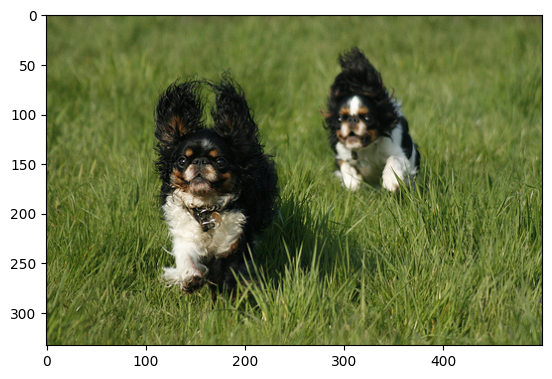

In [73]:
caption = generate_caption(1, unq_valid_imgs.iloc[70]['image']) # Assign the return value of the function to the variable "caption"
translated_caption = translator.translate(str(caption))
print("\nTranslated Caption:")
print(translated_caption)